In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
parser = PDBParser()
parser = PDBParser(PERMISSIVE=1)


filename_Config1 =r'C:\Users\bashc\Downloads\2pzs_clean.pdb'
filename_config2 = r'C:\Users\bashc\Downloads\2pyj_clean.pdb'

outputScriptFile = r'D:\PythonProj\MDSimulations\moves.cxc'

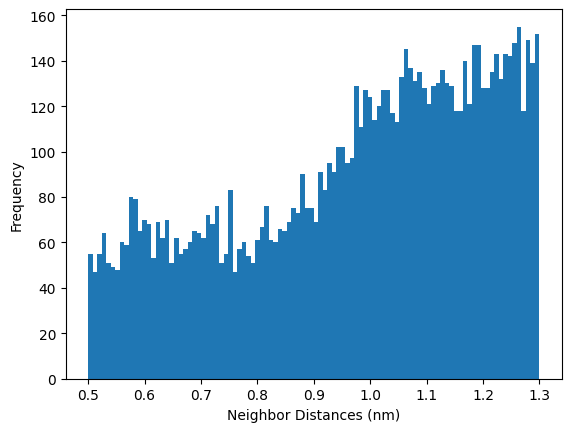

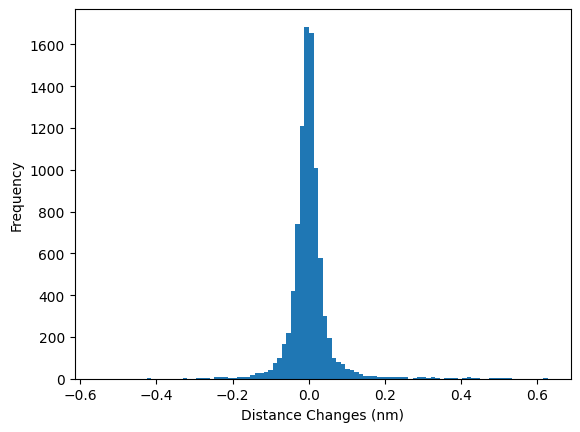

In [8]:
structure = parser.get_structure('x', filename_Config1)

residues = [] 
#walk through chains and get all residues and COM
for model in structure:
        for chain in model:
            for residue in chain.get_residues():
                coordsA =np.array( residue.center_of_mass())
                residues.append({'model':model.id,'chain': chain.id,'residue': residue.get_id()[1], 'amino': residue.get_resname(),'com':coordsA})
                
#find residues that are close to each other so we can compare closeness after the open/close step                
neighbors = []
for i in range(len(residues)):
    for j in range(i+1, len(residues)):
        distance = np.linalg.norm(residues[i]['com'] - residues[j]['com'])/10.0
        if distance < 1.3 and distance>.5:
            neighbors.append({'residue1': residues[i], 'residue2': residues[j], 'distance': distance})

#nice plot of distance distribution            
distances = [x['distance'] for x in neighbors]
plt.hist(distances, bins=100)
plt.xlabel('Neighbor Distances (nm)')
plt.ylabel('Frequency')
plt.show()                  

#open the second pdb and get the same residues as before 
structure = parser.get_structure('x', filename_config2)
residues2 = {}
for model in structure:
        for chain in model:
            for residue in chain.get_residues():
                coordsA =np.array( residue.center_of_mass())
                residues2[residue.get_id()[1]]=({'model':model.id,'chain': chain.id,'residue': residue.get_id()[1], 'amino': residue.get_resname(),'com':coordsA})
    
    
    
#walk through the neighbors and find the new distances between the residues selected before    
distanceChanges = []
blues = []
greens = [] 
yellows = []
oranges = []
reds = []
extras = ""
cc=0
contactR1=""
contactR2=""
for neighbor in neighbors:
    #make sure the new residues are still named
    if neighbor['residue1']['residue'] in residues2 and neighbor['residue2']['residue'] in residues2:
        #get the new distance
        newDistance = np.linalg.norm(residues2[neighbor['residue1']['residue']]['com'] - residues2[neighbor['residue2']['residue']]['com'])/10.0
        
        delta = newDistance - neighbor['distance']
        
        #add a nice record for more graphing if wanted
        distanceChanges.append({'residue1': neighbor['residue1']['residue'],
                                'residue2': neighbor['residue2']['residue'], 
                                'distance':neighbor['distance'], 
                                'delta': delta})
            
        #color the residues based on the delta
        if np.abs(delta) <.1 :
            blues.append(neighbor['residue1']['residue'])
            blues.append(neighbor['residue2']['residue'])
        elif np.abs(delta) <.2 :
            greens.append(neighbor['residue1']['residue'])
            greens.append(neighbor['residue2']['residue'])
            contactR1+=f"/{neighbor['residue1']['chain']}:{neighbor['residue1']['residue']}@CA "
            contactR2+=f"/{neighbor['residue2']['chain']}:{neighbor['residue2']['residue']}@CA "
            #extras += f"contacts /a:{neighbor['residue1']['residue']}@CA restrict /a:{neighbor['residue2']['residue']}@CA distanceOnly 15 reveal true name aros{cc}\n"
            cc+=1
        elif np.abs(delta) <.3 :
            yellows.append(neighbor['residue1']['residue'])
            yellows.append(neighbor['residue2']['residue'])
           
        elif np.abs(delta) <.4 :
            oranges.append(neighbor['residue1']['residue'])
            oranges.append(neighbor['residue2']['residue'])
        else :
            reds.append(neighbor['residue1']['residue'])
            reds.append(neighbor['residue2']['residue'])
 
extras =""# f"contacts {contactR1} restrict {contactR2} distanceOnly 12 reveal true name aros\n" 
#create script to color the residues in chimeraX                
blues = list(set(blues))
greens = list(set(greens))
yellows = list(set(yellows))
oranges = list(set(oranges))
reds = list(set(reds))
good = "select "
for x in blues:
    good += f"/d:{x} "
good += "\ncolor sel dim gray\nselect "         

for x in greens:
    good += f"/d:{x} "
good += "\ncolor sel green\nselect "         

for x in yellows:
    good += f"/d:{x} "
good += "\ncolor sel yellow\nselect "                  


for x in oranges:
    good += f"/d:{x} "
good += "\ncolor sel orange\nselect "               


for x in reds:
    good += f"/d:{x} "
good += "\ncolor sel red\n "                 

good += "\n" + extras        

with open(outputScriptFile, "w") as file:
    file.write(good)
    
    
deltas = [x['delta'] for x in distanceChanges]
plt.hist(deltas, bins=100)
plt.xlabel('Distance Changes (nm)')
plt.ylabel('Frequency')
plt.show()    